In [ ]:
#'cffex-host-alarm.csv' process code
#Author: 普俊韬
#Last update: 20180626

#导入pandas、numpy库
import pandas as pd
import numpy as np


#TODO：进行原始数据的分割处理

#读取原始数据（GBK编码，数据不带列标题）
data = pd.read_csv('raw_data\cffex-host-alarm.csv',encoding = 'GBK', header = None)

#分割数据字段，分隔符'|||'（'[|]+'),分割后扩展列
data_processed = data[0].str.split('[|]+',expand = True)

#插入列标题
data_processed.columns = ['node_name', 'node_alias', 'component', 'category', 'alarm_count', 'first_time', 'last_time', 'alarm_level', 'alarm_content']


#TODO：进行'component'字段的处理

#将'component'字段提取出来作为一个DataFrame
data_component = data_processed.loc[:,['component']]

#去掉重复数据
data_component_processed = data_component.drop_duplicates()

#插入id列，编号从1开始
data_component_processed['id'] = range(1,len(data_component_processed) + 1)

#将列顺序调整为['id', 'component']
data_component_processed = data_component_processed[['id','component']]

#将处理后结果写入'cffex-host-alarm-component.csv'（不带行标签，GBK编码）
data_component_processed.to_csv('output_data\cffex-host-alarm-component.csv', index = 0, encoding = 'GBK')


#TODO：进行'category'字段的处理

#将'category'字段提取出来作为一个DataFrame
data_category = data_processed.loc[:,['category']]

#去掉重复数据
data_category_processed = data_category.drop_duplicates()

#插入id列，编号从1开始
data_category_processed['id'] = range(1,len(data_category_processed) + 1)

#将列顺序调整为['id', 'category']
data_category_processed = data_category_processed[['id','category']]

#将处理后结果写入'cffex-host-alarm-category.csv'（不带行标签，GBK编码）
data_category_processed.to_csv('output_data\cffex-host-alarm-category.csv', index = 0, encoding = 'GBK')


#TODO：将'component'和'category'字段替换为对应的'id'值，方便后续的数据处理

#对'component'字段进行查找和替换
data_processed['component'] = data_processed['component'].replace(data_component_processed['component'].tolist(),data_component_processed['id'].tolist())

#对'category'字段进行查找和替换
data_processed['category'] = data_processed['category'].replace(data_category_processed['category'].tolist(),data_category_processed['id'].tolist())

#将处理后结果写入'cffex-host-alarm-processed.csv'（不带行标签，GBK编码）
data_processed.to_csv('output_data\cffex-host-alarm-processed.csv', index = 0, encoding = 'GBK')



avgvalue    float64
dataname     object
hostname     object
maxtime     float64
maxvalue    float64
mintime     float64
minvalue    float64
dtype: object
<class 'pandas.core.series.Series'>


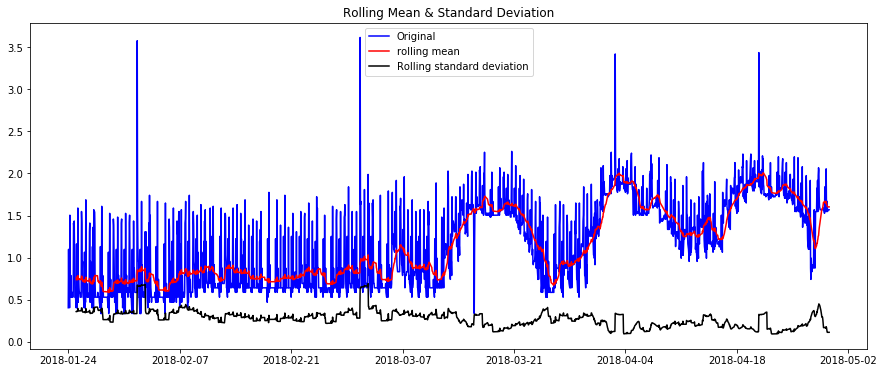

Results of Dickey-Fuller Test:
Test Statistic                   -1.772582
p-value                           0.394156
#Lags Used                       26.000000
Number of Observations Used    2173.000000
Critical value (1%)              -3.433363
Critical value (5%)              -2.862871
Critical value (10%)             -2.567479
dtype: float64
ACF-PACF:


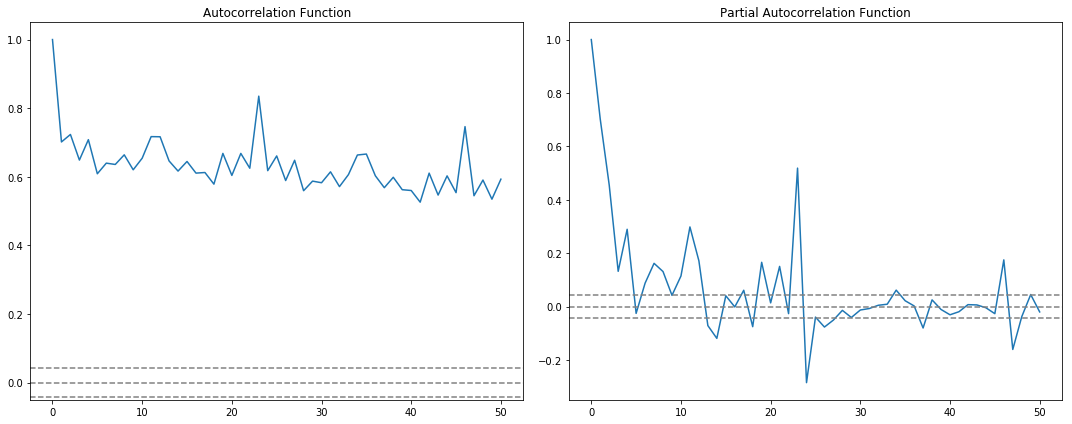

Time Series Decompose:


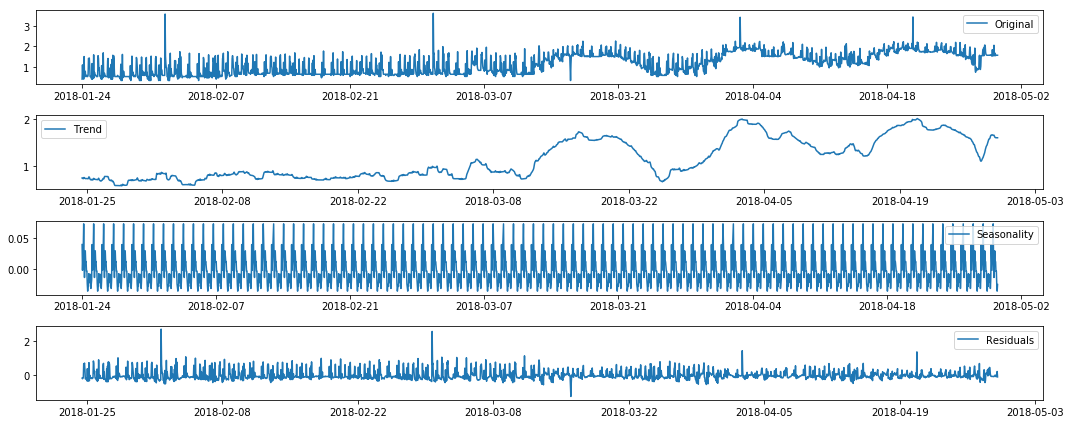

MA(Moving Average):


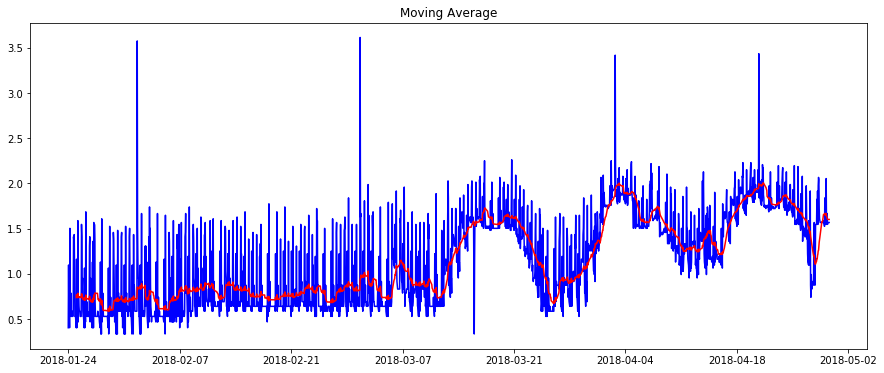

MSE: 0.0882
RMSE: 0.2970
MAE: 0.2105
R-Square: 0.6526
ARIMA:


e:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


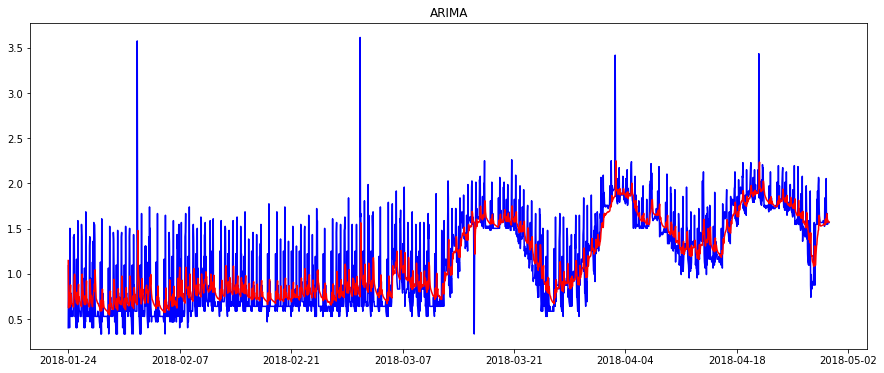

MSE: 0.0876
RMSE: 0.2959
MAE: 0.2065
R-Square: 0.6551
ES[1]:


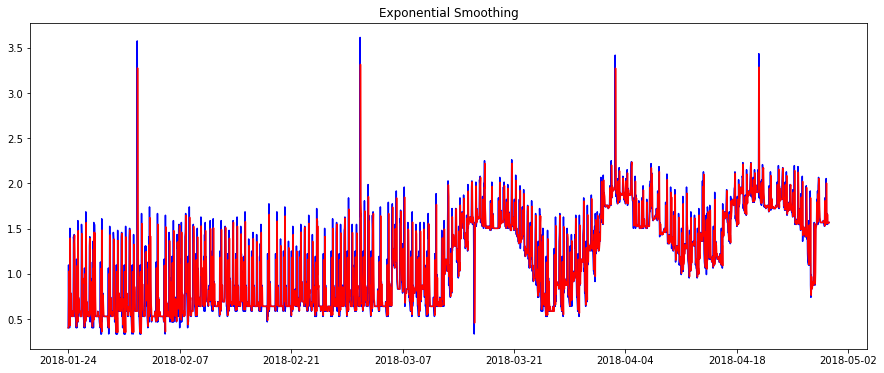

MSE: 0.1368
RMSE: 0.3698
MAE: 0.2200
R-Square: 0.4613
ES[2]:


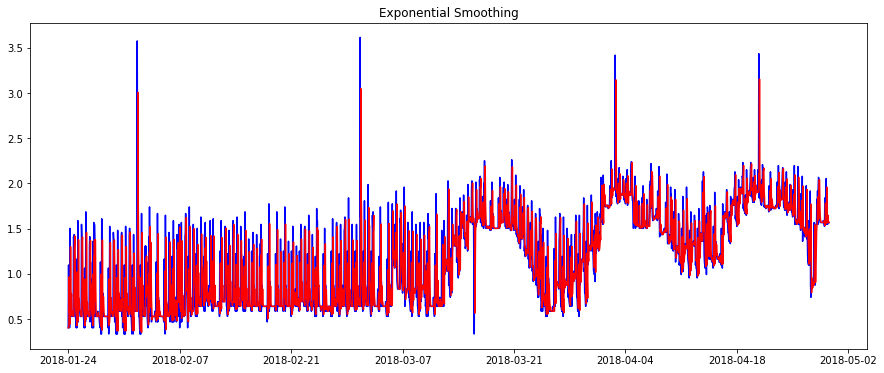

MSE: 0.1229
RMSE: 0.3506
MAE: 0.2146
R-Square: 0.5158
NAIVE:


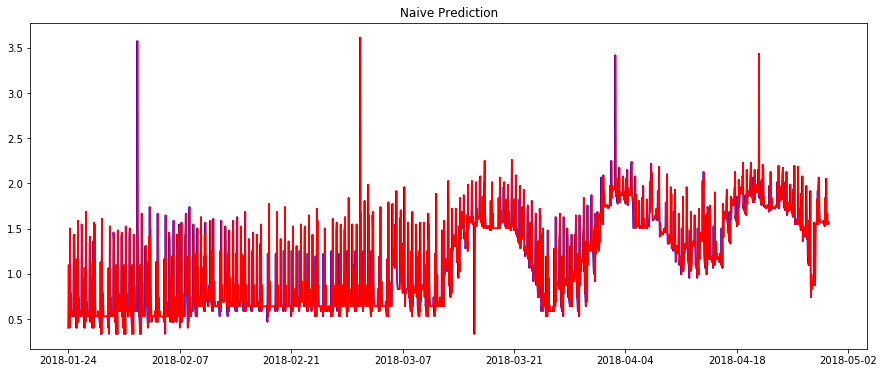

MSE: 0.1512
RMSE: 0.3888
MAE: 0.2306
R-Square: 0.4045
EWMA:


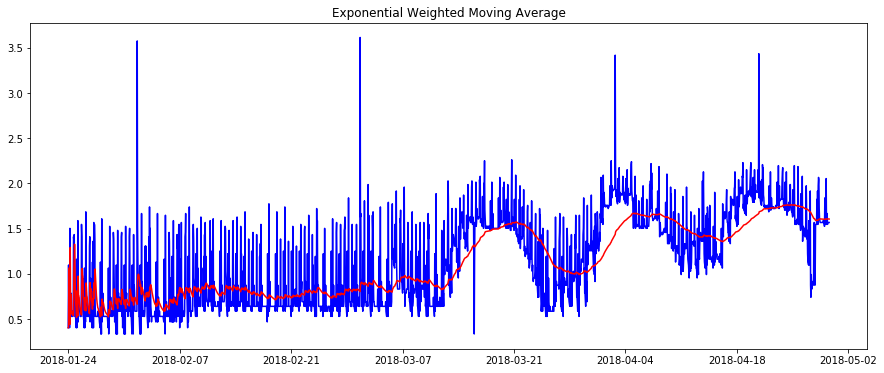

MSE: 0.1176
RMSE: 0.3429
MAE: 0.2548
R-Square: 0.5367


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


rcParams['figure.figsize'] = 15,6

dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')

data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_config3_hourly_cpu.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse,nrows=2200)

# data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_z_w1_ikey01_hourly_cpu.csv',
#                    encoding='UTF-8',nrows=1000)
print(data.dtypes)

ts_maxvalue = data['maxvalue']
print(type(ts_maxvalue))
ts_maxvalue_log = np.log(ts_maxvalue)

#168
# 稳定性检测
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window = 24).mean()
    rolstd = timeseries.rolling(window = 24).std()
    
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'rolling mean')
    std = plt.plot(rolstd,color = 'black', label = 'Rolling standard deviation')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #dickey-Fuller test:
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
        
    print (dfoutput)
        
        
        
# 时间序列分解
def decompose(timeseries):
    decomposition = seasonal_decompose(timeseries,freq=24)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(ts_maxvalue_log,label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend,label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual,label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return trend,seasonal,residual

# 时间序列分解调用
# trend,seasonal,residual = decompose(ts_maxvalue_log)
# residual.dropna(inplace=True)
# test_stationarity(residual)


# 自相关、偏自相关图
def ACF_PACF(timeseries):
    lag_acf = acf(timeseries, nlags = 50)
    lag_pacf = pacf(timeseries, nlags = 50, method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    plt.show()


# ARIMA模型
def ARIMA_Pre(timeseries,order):
    model = ARIMA(timeseries,order)
    results_ARIMA= model.fit(disp=-1)
    plt.plot(timeseries, color = 'blue')
    plt.plot(results_ARIMA.fittedvalues,color='red')
#     plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-timeseries)**2))
    plt.title('ARIMA')
    plt.show(block=False)
    
    return results_ARIMA.fittedvalues

# MA模型
def MA(timeseries, ordered_window):
    moving_avg = timeseries.rolling(window = ordered_window).mean()
    plt.plot(timeseries, color = 'blue')
    plt.plot(moving_avg, color = 'red')
    plt.title('Moving Average')
    plt.show(block=False)
    return moving_avg

# ES模型
def ES(alpha, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1]+(1-alpha)*ES_TS[i-1]
    
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(ES_TS, color = 'red')
    plt.title('Exponential Smoothing')
    plt.show(block=False)
    return ES_TS

def ES_P(alpha, beta, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    ES_Trend = ES_TS.copy(deep=True)
    ES_Final = ES_TS.copy(deep=True)
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1] + (1-alpha)*ES_TS[i-1]
        ES_Trend[i] = (1-beta)*ES_Trend[i-1] + beta*(ES_TS[i]-ES_TS[i-1])
        ES_Final[i] = ES_TS[i] + ES_Trend[i]
        
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(ES_Final, color = 'red')
    plt.title('Exponential Smoothing with Trend Adjustment')
    plt.show(block=False)
    return ES_Final

def EWMA(factor, timeseries):
    EWMA_TS = timeseries.copy(deep=True)
    EWMA_TS[EWMA_TS!=0] = 0.0
    EWMA_TS[0] = timeseries[0]
    for i in range(1, len(EWMA_TS)):
        alpha = factor/(i+factor-1)
        EWMA_TS[i] = alpha*timeseries[i-1]+(1-alpha)*EWMA_TS[i-1]
    
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(EWMA_TS, color = 'red')
    plt.title('Exponential Weighted Moving Average')
    plt.show(block=False)
    return EWMA_TS

def Naive(timeseries):
    NAIVE_TS = timeseries.copy(deep=True)
    NAIVE_TS[NAIVE_TS!=0] = 0.0
    NAIVE_TS[0] = timeseries[0]
    for i in range(1, len(NAIVE_TS)):
        NAIVE_TS[i] = timeseries[i-1]
    
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(NAIVE_TS, color = 'red')
    plt.title('Naive Prediction')
    plt.show(block=False)
    return NAIVE_TS
    
# 回归预测评价
def evaluate(timeseries,results):
    print('MSE: %.4f'% mean_squared_error(timeseries,results))
    print('RMSE: %.4f'% (mean_squared_error(timeseries,results))**0.5)
    print('MAE: %.4f'% mean_absolute_error(timeseries,results))
    print('R-Square: %.4f'% r2_score(timeseries,results))
    

# 稳定性检测
test_stationarity(ts_maxvalue_log)

# ACF-PACF
print('ACF-PACF:')
ACF_PACF(ts_maxvalue_log)

# 时间序列分解
print('Time Series Decompose:')
decompose(ts_maxvalue_log)

# MA结果
print('MA(Moving Average):')
MA_results = MA(ts_maxvalue_log, 24)
nan = np.isnan(MA_results)
MA_results[nan] = 0
evaluate(ts_maxvalue_log, MA_results)

# ARIMA结果
print('ARIMA:')
ARIMA_results = ARIMA_Pre(ts_maxvalue_log,(3,0,1))
evaluate(ts_maxvalue_log, ARIMA_results)

# ES结果
print('ES[1]:')
alpha = .90#设置alphe，即平滑系数
ES_results = ES(alpha,ts_maxvalue_log)
evaluate(ts_maxvalue_log, ES_results)
print('ES[2]:')
ES2_results = ES(alpha, ES_results)
evaluate(ts_maxvalue_log, ES2_results)

# # ES_P结果
# print('ES_P:')
# alpha = .70#设置alphe，即平滑系数
# beta = .60#设置beta，即趋势调整系数
# ES_P_results = ES_P(alpha,beta,ts_maxvalue_log)
# evaluate(ts_maxvalue_log, ES_P_results)

# Naive结果
print('NAIVE:')
NAIVE_results = Naive(ts_maxvalue_log)
evaluate(ts_maxvalue_log, NAIVE_results)

# EWMA结果
print('EWMA:')
factor = 20
EWMA_results = EWMA(factor,ts_maxvalue_log)
evaluate(ts_maxvalue_log, EWMA_results)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import os, sys, json, csv, re
import pywt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

rcParams['figure.figsize'] = 15,6

# ARIMA模型
def ARIMA(timeseries,order):
    model = ARIMA(timeseries,order)
    results_ARIMA= model.fit(disp=-1)
    return results_ARIMA.fittedvalues

# MA模型
def MA(timeseries, ordered_window):
    moving_avg = timeseries.rolling(window = ordered_window).mean()
    return moving_avg

# ES模型
def ES(alpha, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1]+(1-alpha)*ES_TS[i-1]
    return ES_TS

# 指数平滑趋势调整模型
def ES_P(alpha, beta, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    ES_Trend = ES_TS.copy(deep=True)
    ES_Final = ES_TS.copy(deep=True)
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1] + (1-alpha)*ES_TS[i-1]
        ES_Trend[i] = (1-beta)*ES_Trend[i-1] + beta*(ES_TS[i]-ES_TS[i-1])
        ES_Final[i] = ES_TS[i] + ES_Trend[i]
    return ES_Final

# 指数加权平均模型
def EWMA(factor, timeseries):
    EWMA_TS = timeseries.copy(deep=True)
    EWMA_TS[EWMA_TS!=0] = 0.0
    EWMA_TS[0] = timeseries[0]
    for i in range(1, len(EWMA_TS)):
        alpha = factor/(i+factor-1)
        EWMA_TS[i] = alpha*timeseries[i-1]+(1-alpha)*EWMA_TS[i-1]
    return EWMA_TS

# Naive模型
def Naive(timeseries):
    NAIVE_TS = timeseries.copy(deep=True)
    NAIVE_TS[NAIVE_TS!=0] = 0.0
    NAIVE_TS[0] = timeseries[0]
    for i in range(1, len(NAIVE_TS)):
        NAIVE_TS[i] = timeseries[i-1]
    return NAIVE_TS

#小波变换
def Wavelet(timeseries, predictlen):
    index_list = np.array(timeseries)[:-predictlen]
    date_list1 = np.array(timeseries.index)[:-predictlen]

    index_for_predict = np.array(timeseries)[-predictlen:]
    date_list2 = np.array(timeseries.index)[-predictlen:]

    #分解
    A2,D2,D1 = pywt.wavedec(index_list,'db4',mode='sym',level=2)
    coeff=[A2,D2,D1]

    # 对每层小波系数求解模型系数
    order_A2 = sm.tsa.arma_order_select_ic(A2,ic='aic')['aic_min_order']
    order_D2 = sm.tsa.arma_order_select_ic(D2,ic='aic')['aic_min_order']
    order_D1 = sm.tsa.arma_order_select_ic(D1,ic='aic')['aic_min_order']

    # print order_A2,order_D2,order_D1

    #对每层小波系数构建ARMA模型
    model_A2 = ARMA(A2,order=order_A2)
    model_D2 = ARMA(D2,order=order_D2)
    model_D1 = ARMA(D1,order=order_D1)

    results_A2 = model_A2.fit()
    results_D2 = model_D2.fit()
    results_D1 = model_D1.fit()

    A2_all,D2_all,D1_all = pywt.wavedec(np.array(timeseries),'db4',mode='sym',level=2)
    delta = [len(A2_all)-len(A2),len(D2_all)-len(D2),len(D1_all)-len(D1)]

    pA2 = model_A2.predict(params=results_A2.params,start=1,end=len(A2)+delta[0])
    pD2 = model_D2.predict(params=results_D2.params,start=1,end=len(D2)+delta[1])
    pD1 = model_D1.predict(params=results_D1.params,start=1,end=len(D1)+delta[2])

    coeff_new = [pA2,pD2,pD1]
    denoised_index = pywt.waverec(coeff_new,'db4')

    temp_data_wt = {'real_value':timeseries[-predictlen:],'pre_value_wt':denoised_index[-predictlen:]
               ,'err_wt':denoised_index[-predictlen:]-index_for_predict
                ,'err_rate_wt/%':(denoised_index[-predictlen:]-index_for_predict)/index_for_predict*100}
    predict_wt = pd.DataFrame(temp_data_wt,index=date_list2,columns=['real_value','pre_value_wt','err_wt','err_rate_wt/%'])
    
    return denoised_index[-predictlen:],predict_wt


csv_dir = r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info'
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')
f_list = os.listdir(csv_dir)

predict_result = pd.DataFrame(columns=['file','NAIVE_R-Square','MA_24_R-Square','MA_72_R-Square','MA_120_R-Square','MA_168_R-Square',
                                          'ES1_0.1_R-Square','ES1_0.3_R-Square','ES1_0.5_R-Square','ES1_0.7_R-Square','ES1_0.9_R-Square',
                                          'ES2_0.1_R-Square','ES2_0.3_R-Square','ES2_0.5_R-Square','ES2_0.7_R-Square','ES2_0.9_R-Square',
                                          'EWMA_2_R-Square','EWMA_4_R-Square','EWMA_6_R-Square','EWMA_8_R-Square','EWMA_10_R-Square','Wavelet_R-Square'])
for i in f_list:
    data = pd.read_csv(os.path.join(csv_dir,i),encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse)
    ts_maxvalue = data['maxvalue']
    
#     #Naive
#     NAIVE_results = Naive(ts_maxvalue)
# #     NAIVE_r2 = r2_score(ts_maxvalue,NAIVE_results)
#     NAIVE_MAE = mean_absolute_error(ts_maxvalue, NAIVE_results)
    
#     #MA-Max-24
#     MA_Max_results_24 = MA(ts_maxvalue, 24)
#     nan = np.isnan(MA_Max_results_24)
#     MA_Max_results_24[nan] = 0
#     inf = np.isinf(MA_Max_results_24)
#     MA_Max_results_24[inf] = 0
# #     MA_r2_24 = r2_score(ts_maxvalue,MA_Max_results)
#     MA_MAE_24 = mean_absolute_error(ts_maxvalue,MA_Max_results_24)
    
#     #MA-Max-72
#     MA_Max_results_72 = MA(ts_maxvalue, 72)
#     nan = np.isnan(MA_Max_results_72)
#     MA_Max_results_72[nan] = 0
#     inf = np.isinf(MA_Max_results_72)
#     MA_Max_results_72[inf] = 0
# #     MA_r2_72 = r2_score(ts_maxvalue,MA_Max_results)
#     MA_MAE_72 = mean_absolute_error(ts_maxvalue,MA_Max_results_72)
    
#     #MA-Max-120
#     MA_Max_results_120 = MA(ts_maxvalue, 120)
#     nan = np.isnan(MA_Max_results_120)
#     MA_Max_results_120[nan] = 0
#     inf = np.isinf(MA_Max_results_120)
#     MA_Max_results_120[inf] = 0
# #     MA_r2_120 = r2_score(ts_maxvalue,MA_Max_results)
#     MA_MAE_120 = mean_absolute_error(ts_maxvalue,MA_Max_results_120)
    
#     #MA-Max-168
#     MA_Max_results_168 = MA(ts_maxvalue, 168)
#     nan = np.isnan(MA_Max_results_168)
#     MA_Max_results_168[nan] = 0
#     inf = np.isinf(MA_Max_results_168)
#     MA_Max_results_168[inf] = 0
# #     MA_r2_168 = r2_score(ts_maxvalue,MA_Max_results)
#     MA_MAE_168 = mean_absolute_error(ts_maxvalue,MA_Max_results_168)
    
    
#     #ES1-Max-0.1
#     alpha = .10#设置alphe，即平滑系数
#     ES1_Max_results_1 = ES(alpha,ts_maxvalue)
# #     ES1_r2_1 = r2_score(ts_maxvalue,ES1_Max_results)
#     ES1_MAE_1 = mean_absolute_error(ts_maxvalue,ES1_Max_results_1)
    
#     #ES1-Max-0.3
#     alpha = .30#设置alphe，即平滑系数
#     ES1_Max_results_3 = ES(alpha,ts_maxvalue)
# #     ES1_r2_3 = r2_score(ts_maxvalue,ES1_Max_results)
#     ES1_MAE_3 = mean_absolute_error(ts_maxvalue,ES1_Max_results_3)
    
#     #ES1-Max_0.5
#     alpha = .50#设置alphe，即平滑系数
#     ES1_Max_results_5 = ES(alpha,ts_maxvalue)
# #     ES1_r2_5 = r2_score(ts_maxvalue,ES1_Max_results)
#     ES1_MAE_5 = mean_absolute_error(ts_maxvalue,ES1_Max_results_5)
    
#     #ES1-Max-0.7
#     alpha = .70#设置alphe，即平滑系数
#     ES1_Max_results_7 = ES(alpha,ts_maxvalue)
# #     ES1_r2_7 = r2_score(ts_maxvalue,ES1_Max_results)
#     ES1_MAE_7 = mean_absolute_error(ts_maxvalue,ES1_Max_results_7)
    
#     #ES1-Max-0.9    
#     alpha = .90#设置alphe，即平滑系数
#     ES1_Max_results_9 = ES(alpha,ts_maxvalue)
# #     ES1_r2_9 = r2_score(ts_maxvalue,ES1_Max_results)
#     ES1_MAE_9 = mean_absolute_error(ts_maxvalue,ES1_Max_results_9)
    

#     #ES2-Max-0.1
#     alpha = .10#设置alphe，即平滑系数
#     ES1_Max_results = ES(alpha,ts_maxvalue)
#     ES2_Max_results_1 = ES(alpha,ES1_Max_results)
# #     ES2_r2_1 = r2_score(ts_maxvalue,ES2_Max_results)
#     ES2_MAE_1 = mean_absolute_error(ts_maxvalue,ES2_Max_results_1)
    
#     #ES2-Max-0.3
#     alpha = .30#设置alphe，即平滑系数
#     ES1_Max_results = ES(alpha,ts_maxvalue)
#     ES2_Max_results_3= ES(alpha,ES1_Max_results)
# #     ES2_r2_3 = r2_score(ts_maxvalue,ES2_Max_results)
#     ES2_MAE_3 = mean_absolute_error(ts_maxvalue,ES2_Max_results_3)
    
#     #ES2-Max_0.5
#     alpha = .50#设置alphe，即平滑系数
#     ES1_Max_results = ES(alpha,ts_maxvalue)
#     ES2_Max_results_5 = ES(alpha,ES1_Max_results)
# #     ES2_r2_5 = r2_score(ts_maxvalue,ES2_Max_results)
#     ES2_MAE_5 = mean_absolute_error(ts_maxvalue,ES2_Max_results_5)
    
#     #ES2-Max-0.7
#     alpha = .70#设置alphe，即平滑系数
#     ES1_Max_results = ES(alpha,ts_maxvalue)
#     ES2_Max_results_7 = ES(alpha,ES1_Max_results)
# #     ES2_r2_7 = r2_score(ts_maxvalue,ES2_Max_results)
#     ES2_MAE_7 = mean_absolute_error(ts_maxvalue,ES2_Max_results_7)
    
#     #ES2-Max-0.9    
#     alpha = .90#设置alphe，即平滑系数
#     ES1_Max_results = ES(alpha,ts_maxvalue)
#     ES2_Max_results_9 = ES(alpha,ES1_Max_results)
# #     ES2_r2_9 = r2_score(ts_maxvalue,ES2_Max_results)
#     ES2_MAE_9 = mean_absolute_error(ts_maxvalue,ES2_Max_results_9)
    
#     #EWMA-Max-2
#     factor = 2
#     EWMA_Max_results_2 = EWMA(factor,ts_maxvalue)
# #     EWMA_r2_2 = r2_score(ts_maxvalue,EWMA_Max_results)
#     EWMA_MAE_2 = mean_absolute_error(ts_maxvalue,EWMA_Max_results_2)
    
#     #EWMA-Max-4
#     factor = 4
#     EWMA_Max_results_4 = EWMA(factor,ts_maxvalue)
# #     EWMA_r2_4 = r2_score(ts_maxvalue,EWMA_Max_results)
#     EWMA_MAE_4 = mean_absolute_error(ts_maxvalue,EWMA_Max_results_4)
    
#     #EWMA-Max-6
#     factor = 6
#     EWMA_Max_results_6 = EWMA(factor,ts_maxvalue)
# #     EWMA_r2_6 = r2_score(ts_maxvalue,EWMA_Max_results)
#     EWMA_MAE_6 = mean_absolute_error(ts_maxvalue,EWMA_Max_results_6)
    
#     #EWMA-Max-8
#     factor = 8
#     EWMA_Max_results_8 = EWMA(factor,ts_maxvalue)
# #     EWMA_r2_8 = r2_score(ts_maxvalue,EWMA_Max_results)
#     EWMA_MAE_8 = mean_absolute_error(ts_maxvalue,EWMA_Max_results_8)
    
#     #EWMA-Max-10
#     factor = 10
#     EWMA_Max_results_10 = EWMA(factor,ts_maxvalue)
# #     EWMA_r2_10 = r2_score(ts_maxvalue,EWMA_Max_results)
#     EWMA_MAE_10 = mean_absolute_error(ts_maxvalue,EWMA_Max_results_10)
    
    #Wavelet-Max
    Wavelet_results,predict_compare = Wavelet(ts_maxvalue,500)
#     Wavelet_r2 = r2_score(ts_maxvalue[-500:],Wavelet_results)
    Wavelet_MAE = mean_absolute_error(ts_maxvalue[-500:],Wavelet_results)
    predict_compare.to_csv(os.path.join('output_data\wavelet',i))
    
    
    print(os.path.join(csv_dir,i))
    
    
    
#     写入csv
    predict_result = predict_result.append({'file':os.path.splitext(i)[0],
#                                             'NAIVE_MAE':NAIVE_MAE,
#                                             'MA_24_MAE':MA_MAE_24,
#                                             'MA_72_MAE':MA_MAE_72,
#                                             'MA_120_MAE':MA_MAE_120,
#                                             'MA_168_MAE':MA_MAE_168,
#                                             'ES1_0.1_MAE':ES1_MAE_1,
#                                             'ES1_0.3_MAE':ES1_MAE_3,
#                                             'ES1_0.5_MAE':ES1_MAE_5,
#                                             'ES1_0.7_MAE':ES1_MAE_7,
#                                             'ES1_0.9_MAE':ES1_MAE_9,
#                                             'ES2_0.1_MAE':ES2_MAE_1,
#                                             'ES2_0.3_MAE':ES2_MAE_3,
#                                             'ES2_0.5_MAE':ES2_MAE_5,
#                                             'ES2_0.7_MAE':ES2_MAE_7,
#                                             'ES2_0.9_MAE':ES2_MAE_9,
#                                             'EWMA_2_MAE':EWMA_MAE_2,
#                                             'EWMA_4_MAE':EWMA_MAE_4,
#                                             'EWMA_6_MAE':EWMA_MAE_6,
#                                             'EWMA_8_MAE':EWMA_MAE_8,
#                                             'EWMA_10_MAE':EWMA_MAE_10
#                                             ,
                                            'Wavelet_MAE':Wavelet_MAE
                                           },ignore_index = True)
    
predict_result.to_csv('output_data\TS_predict_result_diffactor.csv', index = 0, encoding = 'UTF-8')
    
    

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_alarmsvr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_alarmsvr1_hourly_disk.csv


KeyboardInterrupt: 

<class 'pandas.core.series.Series'>
[Timestamp('2018-04-16 13:00:00')]
2018-04-16 14:00:00
2018-04-16 05:00:00    5.9
2018-04-16 06:00:00    4.5
2018-04-16 07:00:00    4.1
2018-04-16 08:00:00    5.0
2018-04-16 09:00:00    5.1
2018-04-16 10:00:00    5.1
2018-04-16 11:00:00    5.4
2018-04-16 12:00:00    5.0
2018-04-16 13:00:00    5.2
2018-04-16 14:00:00    5.2
dtype: float64


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2, 2, 5]
[2.24055271 1.95781228 1.9808444  ... 3.63848064 3.6540402  2.94894947]
                     real_value  pre_value_wt    err_wt  err_rate_wt/%
2018-04-16 05:00:00         5.9      3.405805 -2.494195     -42.274486
2018-04-16 06:00:00         4.5      3.710399 -0.789601     -17.546678
2018-04-16 07:00:00         4.1      3.731331 -0.368669      -8.991917
2018-04-16 08:00:00         5.0      2.988562 -2.011438     -40.228764
2018-04-16 09:00:00         5.1      3.112508 -1.987492     -38.970430
2018-04-16 10:00:00         5.1      3.046638 -2.053362     -40.261997
2018-04-16 11:00:00         5.4      3.344306 -2.055694     -38.068417
2018-04-16 12:00:00         5.0      3.638481 -1.361519     -27.230387
2018-04-16 13:00:00         5.2      3.654040 -1.545960     -29.729996
2018-04-16 14:00:00         5.2      2.948949 -2.251051     -43.289433
-14.548470447115417
2018-04-16 05:00:00    5.9
2018-04-16 06:00:00    4.5
2018-04-16 07:00:00    4.1
2018-04-16 08:00:00    5.0
2018-04-1

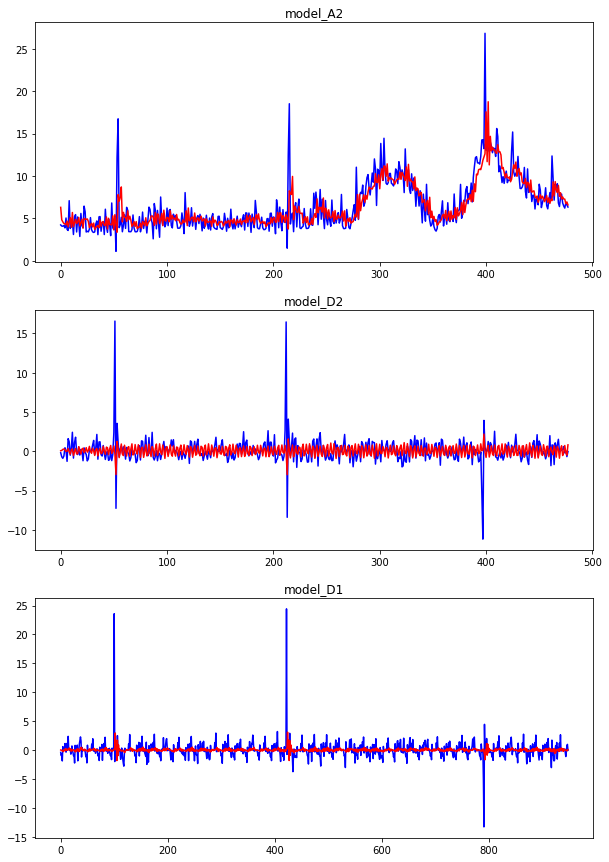

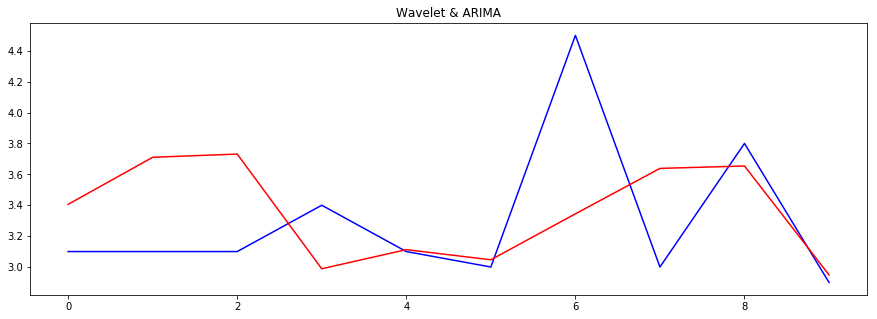

In [43]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pywt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
from datetime import datetime,timedelta

#数据
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')

data1 = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_config3_hourly_cpu.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse,nrows=2200)
timeseries = data1['maxvalue'][:-300]
print(type(timeseries))

last_term_date = timeseries.tail(1).index.tolist()
print(last_term_date)
new_term_date = last_term_date[0] + timedelta(hours = 1)
print(new_term_date)
new_term = pd.Series(timeseries.tail(1)[0], index = [new_term_date])
timeseries = timeseries.append(new_term)
print(timeseries.tail(10))

index_list = np.array(timeseries)[:-10]
date_list1 = np.array(timeseries.index)[:-10]

index_for_predict = np.array(timeseries)[-10:]
date_list2 = np.array(timeseries.index)[-10:]

#分解
A2,D2,D1 = pywt.wavedec(index_list,'db4',mode='sym',level=2)
coeff=[A2,D2,D1]

# 对每层小波系数求解模型系数
order_A2 = sm.tsa.arma_order_select_ic(A2,ic='aic')['aic_min_order']
order_D2 = sm.tsa.arma_order_select_ic(D2,ic='aic')['aic_min_order']
order_D1 = sm.tsa.arma_order_select_ic(D1,ic='aic')['aic_min_order']

# print order_A2,order_D2,order_D1

#对每层小波系数构建ARMA模型
model_A2 = ARMA(A2,order=order_A2)
model_D2 = ARMA(D2,order=order_D2)
model_D1 = ARMA(D1,order=order_D1)

results_A2 = model_A2.fit()
results_D2 = model_D2.fit()
results_D1 = model_D1.fit()

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(A2,'blue')
plt.plot(results_A2.fittedvalues,'red')
plt.title('model_A2')

plt.subplot(3,1,2)
plt.plot(D2,'blue')
plt.plot(results_D2.fittedvalues,'red')
plt.title('model_D2')

plt.subplot(3,1,3)
plt.plot(D1,'blue')
plt.plot(results_D1.fittedvalues,'red')
plt.title('model_D1')

A2_all,D2_all,D1_all = pywt.wavedec(np.array(timeseries),'db4',mode='sym',level=2)
delta = [len(A2_all)-len(A2),len(D2_all)-len(D2),len(D1_all)-len(D1)]

print (delta)

pA2 = model_A2.predict(params=results_A2.params,start=1,end=len(A2)+delta[0])
pD2 = model_D2.predict(params=results_D2.params,start=1,end=len(D2)+delta[1])
pD1 = model_D1.predict(params=results_D1.params,start=1,end=len(D1)+delta[2])

coeff_new = [pA2,pD2,pD1]
denoised_index = pywt.waverec(coeff_new,'db4')

plt.figure(figsize=(15,5))
plt.plot(index_list[-10:],'blue')
plt.plot(denoised_index[-10:],'red')
plt.title('Wavelet & ARIMA')

temp_data_wt = {'real_value':timeseries[-10:],'pre_value_wt':denoised_index[-10:]
               ,'err_wt':denoised_index[-10:]-index_for_predict
                ,'err_rate_wt/%':(denoised_index[-10:]-index_for_predict)/index_for_predict*100}
predict_wt = pd.DataFrame(temp_data_wt,index=date_list2,columns=['real_value','pre_value_wt','err_wt','err_rate_wt/%'])

temp_data_wt2 = {'pre_value_wt':denoised_index[-10:]}
Wavelet_TS = pd.DataFrame(temp_data_wt2,index=date_list2,columns=['pre_value_wt'])
print(denoised_index)
print(predict_wt)
print(r2_score(timeseries[-10:],denoised_index[-10:]))
print(timeseries[-10:])
print(predict_wt['pre_value_wt'][-10:])
print(Wavelet_TS['pre_value_wt'][-10:])


真实数据：qljungbox, pval, qboxpierce, pvalbp: 4363.783652060893 0.0 4363.219734294095 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4371.020341717312 0.0 4370.455177051586 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4416.026677689311 0.0 4415.451819649481 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4516.337669459608 0.0 4515.736885684235 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4517.079500993809 0.0 4516.47849353458 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 8055.354294841493 0.0 8053.533980970427 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 28563.655057792814 0.0 28553.88407810798 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 32562.384182305163 0.0 32550.890726150585 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 32571.428324427998 0.0 32559.93058287332 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 32616.396150227207 0.0 32604.875164480858 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 32710.492821387787 0.0 32698.919143126896 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 32723

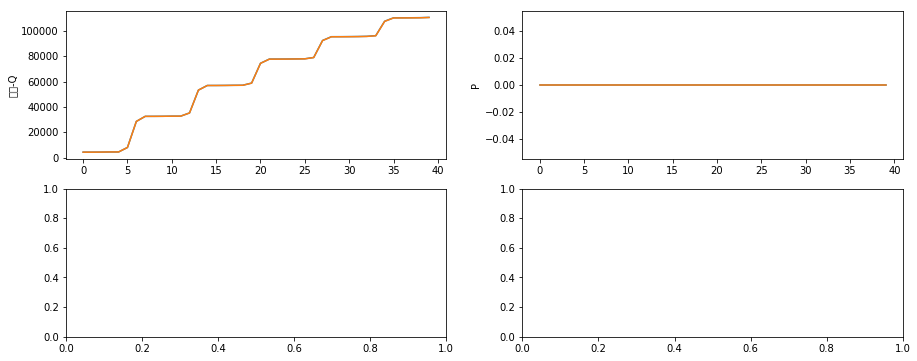

In [4]:
def boxpierce_test():
#     '''计算box pierce 和 box ljung统计量'''
    from statsmodels.sandbox.stats.diagnostic import acorr_ljungbox
    data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_bizbip2_hourly_disk.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse)
    x=data['maxvalue']
    qljungbox, pval, qboxpierce, pvalbp=acorr_ljungbox(x, boxpierce=True)
    count = 0
    for i in range(len(pval)):
        if pval[i] > 0.5:
            count = count+1
        print('真实数据：qljungbox, pval, qboxpierce, pvalbp:',qljungbox[i], pval[i], qboxpierce[i], pvalbp[i])
    print (count)
    fig, axes = plt.subplots(2,2)
    axes[0,0].plot(qljungbox, label='qljungbox');axes[0,0].set_ylabel('真实-Q')
    axes[0,0].plot(qboxpierce, label='qboxpierce')
    axes[0,1].plot(pval, label='pval');axes[0,1].set_ylabel('P')
    axes[0,1].plot(pvalbp, label='pvalbp')
#     x=[random.randint(1, 200) for i in range(data.shape[0])]
#     qljungbox, pval, qboxpierce, pvalbp=acorr_ljungbox(x, boxpierce=True)
#     axes[1,0].plot(qljungbox, label='qljungbox');axes[1,0].set_ylabel('随机-Q')
#     axes[1,0].plot(qboxpierce, label='qboxpierce')
#     axes[1,1].plot(pval, label='pval');axes[1,1].set_ylabel('P')
#     axes[1,1].plot(pvalbp, label='pvalbp')
#     axes[0,0].legend()
#     axes[0,1].legend()
#     axes[1,0].legend()
#     axes[1,1].legend()
#     plt.savefig('../imgs/boxpierce_test.png')
    plt.show()
#     print('随机数据：qljungbox, pval, qboxpierce, pvalbp:',qljungbox, pval, qboxpierce, pvalbp)
if __name__=='__main__':
    boxpierce_test()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import sqrt
from datetime import datetime,timedelta
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


rcParams['figure.figsize'] = 15,6

dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')

data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_mdplatform1_hourly_cpu.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse)
# datalist = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_config3_hourly_cpu.csv',
#                    encoding='UTF-8',nrows=100)

# dataseries = data['maxvalue']
# test = datalist.tail(1)['archour']

# testlist = list(test)

# value = str(testlist[0])

# result = datetime.strptime(value, '%Y%m%d%H')
# result = result + timedelta(hours =1)
# test_result = dataseries.tail(1).index.tolist()
# final_result = test_result[0] + timedelta(hours =1)
# # print(result)
# # newdata = pd.DataFrame({'avgvalue':1.2,'dataname':'sdaw','hostname':'sdaw','maxtime':153,'maxvalue':15,'mintime':153,'minvalue':418},index=[result])
# newdata = pd.Series(1.4,index=[final_result])
# dataseries = dataseries.append(newdata)
# print(dataseries)
# print(type(dataseries.tail(1).index.tolist()))
# print(result)
# print(final_result)


def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

datatrain = data['maxvalue'][:-100]
# print(datatrain)
datatemp = timeseries_to_supervised(datatrain,lag=1)

datatrain = np.array(datatrain).reshape(-1,1)

datavarify = datatemp.iloc[:,0]
# print(datavarify)
datatesttmp = data['maxvalue'][-100:]
# print(datatest)

datatest = np.array(datatesttmp).reshape(-1,1)

# 随机森林回归
# from sklearn import ensemble
# model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=20)#用20个决策树
# model_RandomForestRegressor.fit(datatrain,datavarify)
# result = model_RandomForestRegressor.predict(datatest)

# SVM回归
# from sklearn import svm
# model_SVR = svm.SVR()
# model_SVR.fit(datatrain,datavarify)
# result = model_SVR.predict(datatest)

# KNN回归
# from sklearn import neighbors
# model_KNeighborsRegressor = neighbors.KNeighborsRegressor()
# model_KNeighborsRegressor.fit(datatrain,datavarify)
# result = model_KNeighborsRegressor.predict(datatest)

# Adaboost回归
# from sklearn import ensemble
# model_AdaBoostRegressor = ensemble.AdaBoostRegressor(n_estimators=50)#用50个决策树
# model_AdaBoostRegressor.fit(datatrain,datavarify)
# result = model_AdaBoostRegressor.predict(datatest)

# GBRT回归
# from sklearn import ensemble
# model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100)#用100个决策树
# model_GradientBoostingRegressor.fit(datatrain,datavarify)
# result = model_GradientBoostingRegressor.predict(datatest)

# Bagging回归
from sklearn.ensemble import BaggingRegressor
model_BaggingRegressor = BaggingRegressor()
model_BaggingRegressor.fit(datatrain,datavarify)
result = model_BaggingRegressor.predict(datatest)


plt.figure(figsize=(10,15))
plt.plot(np.array(datatesttmp),'blue')
plt.plot(result,'red')
plt.show()

rmse = sqrt(mean_squared_error(np.array(datatesttmp),result ))
print(rmse)

<Figure size 1000x1500 with 1 Axes>

7.668498620385723


Term=1, Predicted=-0.872711, Expected=8.700000
Term=2, Predicted=4.317105, Expected=19.500000
Term=3, Predicted=5.550334, Expected=61.500000
Term=4, Predicted=-22.220022, Expected=17.000000
Term=5, Predicted=2.934676, Expected=7.900000
Term=6, Predicted=-1.319694, Expected=6.700000
Term=7, Predicted=1.782011, Expected=17.700000
Term=8, Predicted=0.910694, Expected=55.800000
Term=9, Predicted=-21.000043, Expected=8.400000
Term=10, Predicted=-5.535555, Expected=30.600000
Term=11, Predicted=-27.919797, Expected=18.600000
Term=12, Predicted=-15.326408, Expected=11.900000
Term=13, Predicted=-17.630078, Expected=9.200000
Term=14, Predicted=-18.172737, Expected=23.700000
Term=15, Predicted=-24.024693, Expected=10.200000
Term=16, Predicted=-20.124433, Expected=9.000000
Term=17, Predicted=-21.400029, Expected=8.200000
Term=18, Predicted=-21.330977, Expected=10.600000
Term=19, Predicted=-21.517771, Expected=10.400000
Term=20, Predicted=-21.666151, Expected=9.800000
Term=21, Predicted=-22.053737,

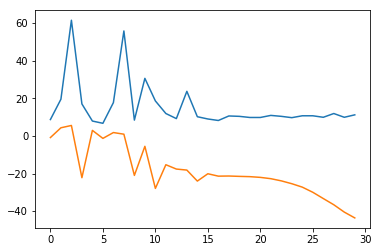

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')

#测试集大小
testlen = 30

# 把序列建构成一个监督学习问题
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# 创建一个差分化序列
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# 反向转换差分化的值
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# 将测试集的数据缩放到[-1,1]范围内
def scale(train, test):
    # fit scale
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# 反缩放预测值
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# 将一个LSTM模型拟合到训练数据集上
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# 做出一步预测
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# 加载数据集
data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_vcsdb1_hourly_cpu.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse,
                   nrows = 50)
series = data['maxvalue']

# 把数据变得平稳
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# 转换数据变成监督学习问题
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# 把数据分成训练数据集和测试数据集
train, test = supervised_values[0:-testlen], supervised_values[-testlen:]
 
# 缩放数据
scaler, train_scaled, test_scaled = scale(train, test)
 
# 拟合模型
lstm_model = fit_lstm(train_scaled, 1, 1500, 5)
# 预测训练集
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# 在测试数据集上的前向验证
predictions = list()
for i in range(len(test_scaled)):
    # 做出一步预测
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # 反向缩放
    yhat = invert_scale(scaler, X, yhat)
    # 反向转换差分化数据
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # 存储预测值
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Term=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    
# 报告模型性能
rmse = sqrt(mean_squared_error(raw_values[-testlen:], predictions))
print(predictions)
print('Test RMSE: %.3f' % rmse)
# 绘制观测值和预测值对比的折线图
pyplot.plot(raw_values[-testlen:])
pyplot.plot(predictions)
pyplot.show()



